In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import scipy.stats as stats
import math
import sklearn.preprocessing
from env import get_db_url

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# train test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

#import acquire
import explore as e
import wrangle_zillow as w
import modeling as m 
#import NAME OF MODEL IMPORT as m

import warnings
warnings.filterwarnings("ignore")

# Acquire


* The data wasfrom the Codeup database using mySQL workbench
* Each observation represents a single family home
* Each column represents a feature of the property
* I acquired this data on Wednesday November 30th 

# Prepare

* Removed nulls from rows then removed columns with most nulls
* Outliers were not identified or intentionally removed
* Year built column changed to age and imputed values to show age of property
* Split data into train, validate and test(approx. 50/30/20)
* Renamed multiple columns : bedrooms, bathrooms, complete square footage 

 

In [2]:
#retrieving data
df = w.get_zillow_data()


In [3]:
columns = ['buildingqualitytypeid','heatingorsystemdesc','heatingorsystemtypeid','unitcnt','propertyzoningdesc','propertylandusedesc','parcelid.1','id.1','censustractandblock']
location = ['latitude','longitude','age']
foundation = ['sqft','lotsizesquarefeet']

In [4]:
# cleaning data
df = w.data_prep(df,columns)

In [5]:
#create, train, validate, test datasetsb
train, validate, test = w.wrangle_zillow(df)

# Exploration of Data

### What is the median and mean logerror? 

In [7]:
# table of logerror mean and median
e.statistic_table(df)

Metric           Value
----------  ----------
Median      0.00684291
Mean        0.0181363
Difference  0.0112934


### Takeaways

- The median logerror is .0069
- The mean logerror is .018
- The difference between these values is .011

# Statistical Questions

### Is there a signfiicant difference in mean logerror across the three counties?

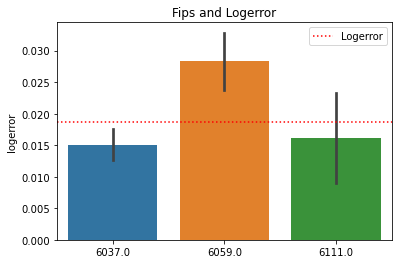

In [8]:
# creates bar chart of logerror
e.bar_chart(train,'fips','logerror')

### Hypothesis

- Ho: There is not a signficant difference in mean between logerror across counties<br>
- Ha: There is a significant difference in mean  between logerror across counties

In [9]:
# Statistical test results
e.stats_property_location(train)

Kruska Result = 53.2321
p = 2.7592338397679317e-12


### Takeaways 

- The counties have signficant differences in their mean log errors
- Orange county appears to have the largest mean logerror



### Is there a correlation between taxamount and logerror?

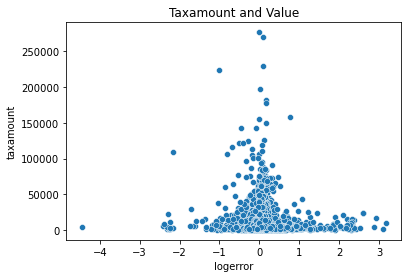

In [10]:
# Visualization 
e.scatter_plot(train)

### Hypothesis: 

Ho: There is is not a correlation between logerror and taxamount<br>
Ha: There is a correlation between logerror and taxamount

In [11]:
# Statistcal test results
e.correlation_stat_test(train,'taxamount')

Correlation Strength = -0.0143
p = 0.01603980724302495


### Takeaways
- There is a correlation beetween the taxamount and the logerror
- As the price of the home increases the log error decreases 




### Is there a significant difference in the mean logerror of homes in the location cluster number one compared to the population?

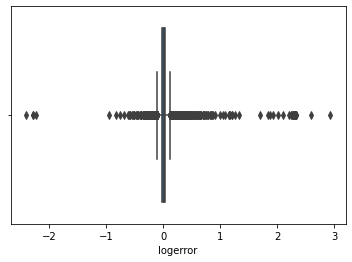

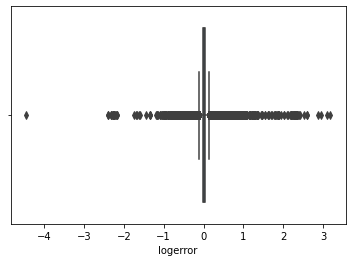

In [12]:
# Visualization
e.boxplots(train,location,5,1)

### Hypothesis: 

Ho: There is not a significant difference in the mean logerror of homes in foundation cluster number two compared to the population<br>
Ha: There is a significant difference in the mean logerror of homes in foundation cluster number two compared to the population

In [13]:
# Statistical test results 
e.ttest(train,location,5,1)

We reject $H_{0}$


(3.9215866859077404, 8.909651845831881e-05)

### Takeaways

- Rejecting the null here implies that this cluster could be a useful feature to help the performance of our model as the mean log error in this cluster is significantly different from the overall popultaion.


### Is there a significant difference in the mean logerror of homes in the location cluster number two compared to the population?

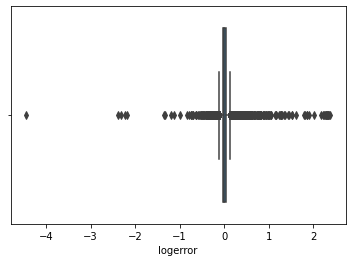

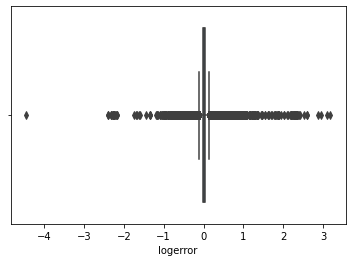

In [14]:
# Visualizations
e.boxplots(train,location,5,2)

### Hypothesis

Ho: There is not a significant difference in the mean logerror of homes in the location cluster number one compared to the population<br>
Ha: There is a significant difference in the mean logerror of homes in the location cluster number one compared to the population

In [15]:
# Statistical test results 
e.ttest(train,location,5,2)

We reject $H_{0}$


(2.0792505008757365, 0.03762105270215126)

### Takeaways
- Rejecting the null here implies that this cluster could be a useful feature to help the performance of our model as the mean log error in this cluster is significantly different from the overall popultaion.


## Exploration Summary

- The median logerror is .0069
- The counties have signficant differences in their mean log errors
- As the price of the home increases the log error decreases 
- There was a set of clusters created based on location features (latitude, longitude, age)
- There was a set of clusters created based on foundation features (square feet and lot size)
- There was a set of clusters created based on structure features (bedrooms and bathrooms)
- Properties within location cluster 1 have a different mean log error to the population
- Properties within location cluster 2 have a different mean log error to the population







# Modeling

### Introduction

- Root Mean Squared error will be used as the evaluation metric
- My baseline model is created from the Root Mean Squared error (RMSE) of the median logerror of the train and validate data set
- The features chosen for modeling are cluster one from the location cluster and cluster two from the foundation cluster
- Models will be evaluated on train and validate data sets 
- The model that performs the best will be evaluated on the test data

In [16]:
# prepare data for models
location_train_model_df = m.make_location_model_df(train,location, 5)
location_validate_model_df = m.make_location_model_df(validate,location,5)
location_test_model_df = m.make_location_model_df(test, location, 5)

In [17]:
# prepare data for models
foundation_train_model_df = m.make_foundation_model_df(train,foundation,4)
foundation_validate_model_df = m.make_foundation_model_df(validate,foundation,4)
foundation_test_model_df = m.make_foundation_model_df(test,foundation,4)

## Baseline Model

In [1]:
# creating baseline model and printing results
m.baseline(train)

NameError: name 'm' is not defined

## LassoLars 

In [ ]:
# Lasso Lars model using location features/clusters

#This is where I create my Lasso Lars model
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model

lars.fit(location_train_model_df, train.logerror)

# predict train
train['logerror_pred_lars'] = lars.predict(location_train_model_df)

# evaluate: rmse
rmse_train = mean_squared_error(train.logerror, train.logerror_pred_lars) ** (1 / 2)

# predict validate
validate['logerror_pred_lars'] = lars.predict(location_validate_model_df)

# evaluate: rmse
rmse_validate = mean_squared_error(validate.logerror,validate.logerror_pred_lars) ** (1 / 2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


In [ ]:
# Lasso Lars model using foundation features/clusters


#This is where I create my Lasso Lars model
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model

lars.fit(foundation_train_model_df, train.logerror)

# predict train
train['logerror_pred_lars'] = lars.predict(foundation_train_model_df)

# evaluate: rmse
rmse_train = mean_squared_error(train.logerror, train.logerror_pred_lars) ** (1 / 2)

# predict validate
validate['logerror_pred_lars'] = lars.predict(foundation_validate_model_df)

# evaluate: rmse
rmse_validate = mean_squared_error(validate.logerror, validate.logerror_pred_lars) ** (1 / 2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


## Polynomial Regression 

In [ ]:
# generating polynomial regression model results using location features/clusters
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2Location = pf.fit_transform(location_train_model_df)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2Location = pf.transform(location_validate_model_df)
x_test_degree2Location = pf.transform(location_test_model_df)

# create the model object
lm2Location = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lm2Location.fit(x_train_degree2Location, train.logerror)

# predict train
train['logerror_pred_lm2Loc'] = lm2Location.predict(x_train_degree2Location)

# evaluate: rmse
rmse_train = mean_squared_error(train.logerror, train.logerror_pred_lm2Loc) ** (1 / 2)

# predict validate
validate['logerror_pred_lm2Loc'] = lm2Location.predict(x_validate_degree2Location)

# evaluate: rmse
rmse_validate = mean_squared_error(validate.logerror, validate.logerror_pred_lm2Loc) ** (1 / 2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# generating polynomial regression model results using location features/clusters
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2Foundation = pf.fit_transform(foundation_train_model_df)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2Foundation = pf.transform(foundation_validate_model_df)
x_test_degree2Foundation = pf.transform(foundation_test_model_df)

# create the model object
lm2Foundation = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lm2Foundation.fit(x_train_degree2Foundation, train.logerror)

# predict train
train['logerror_pred_lm2Found'] = lm2Foundation.predict(x_train_degree2Foundation)

# evaluate: rmse
rmse_train = mean_squared_error(train.logerror, train.logerror_pred_lm2Found) ** (1 / 2)

# predict validate
validate['logerror_pred_lm2Found'] = lm2Foundation.predict(x_validate_degree2Foundation)

# evaluate: rmse
rmse_validate = mean_squared_error(validate.logerror, validate.logerror_pred_lm2Found) ** (1 / 2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)

## Takeaways
- All models perform better than baseline


## Best Model

- ####   Polynomial Regression Model Wins!

## Test Model
- The test data will run through the Polynomial Regression model

In [ ]:
# using model on test dataset 
CODE FOR TEST MODEL

### Modeling Wrap 

* I would not recommend this model for production because it does not perform significantly better than the baseline model

## Conclusion

### Summary

- The median logerror is .0069
- Statistical evidence supports a correlation between taxamount and 
- The counties have signficant differences in their mean log errors
- Properties within location cluster 1 have a different mean log error to the population
- Properties within location cluster 2 have a different mean log error to the population




### Modeling Summary 
- The model uses location cluster 1 and foundation cluster 2
- The final model performed better than the baseline but not significantly better
- I would not recommend this model for production


### Recommendations
* Compare data from 2017 from other years of zillow data and see if similar results are found
* Create models for each county


### Next Steps
* Create a model using the taxamounts column to predict logerror
* Spend more time researching why the logerror mean was highest in Orange County